## Libraries

In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import sqlite3
import h5py
import h5json
from plotnine import *

pd.options.display.max_columns = 999

## Track Metadata

In [14]:
# what's a good threshold to take samples
conn = sqlite3.connect('/storage/thesis/music/AdditionalFiles/track_metadata.db')
songs = pd.read_sql_query("SELECT duration FROM songs", conn)
np.percentile(songs, 2)

# ~98% of the songs are greater than  60 seconds

63.13751

## Musical Features: Compare 2 Methods

In [18]:
def get_time_warp_matrix(segstart, btstart, duration):
    """
    Used by create_beat_synchro_chromagram
    Returns a matrix (#beats,#segs)
    #segs should be larger than #beats, i.e. many events or segs
    happen in one beat.
    THIS FUNCTION WAS ORIGINALLY CREATED BY RON J. WEISS (Columbia/NYU/Google)
    """
    # length of beats and segments in seconds
    # result for track: 'TR0002Q11C3FA8332D'
    #    seglen.shape = (708,)
    #    btlen.shape = (304,)
    #    duration = 238.91546    meaning approx. 3min59s
    seglen = np.concatenate((segstart[1:], [duration])) - segstart
    btlen = np.concatenate((btstart[1:], [duration])) - btstart

    warpmat = np.zeros((len(segstart), len(btstart)))
    # iterate over beats (columns of warpmat)
    for n in range(len(btstart)):
        # beat start time and end time in seconds
        start = btstart[n]
        end = start + btlen[n]
        # np.nonzero returns index of nonzero elems
        # find first segment that starts after beat starts - 1
        try:
            start_idx = np.nonzero((segstart - start) >= 0)[0][0] - 1
        except IndexError:
            # no segment start after that beats, can happen close
            # to the end, simply ignore, maybe even break?
            # (catching faster than ckecking... it happens rarely?)
            break
        # find first segment that starts after beat ends
        segs_after = np.nonzero((segstart - end) >= 0)[0]
        if segs_after.shape[0] == 0:
            end_idx = start_idx
        else:
            end_idx = segs_after[0]
        # fill col of warpmat with 1 for the elem in between
        # (including start_idx, excluding end_idx)
        warpmat[start_idx:end_idx, n] = 1.
        # if the beat started after the segment, keep the proportion
        # of the segment that is inside the beat
        warpmat[start_idx, n] = 1. - ((start - segstart[start_idx])
                                 / seglen[start_idx])
        # if the segment ended after the beat ended, keep the proportion
        # of the segment that is inside the beat
        if end_idx - 1 > start_idx:
            warpmat[end_idx-1, n] = ((end - segstart[end_idx-1])
                                     / seglen[end_idx-1])
        # normalize so the 'energy' for one beat is one
        warpmat[:, n] /= np.sum(warpmat[:, n])
    # return the transpose, meaning (#beats , #segs)
    return warpmat.T

In [68]:
def extract_track_metadata(fname, fixed_dur=True):
    fl = h5py.File(fname, 'r')
    segs_pitch = np.asarray(fl['analysis']['segments_pitches'])
    segs_start = np.asarray(fl['analysis']['segments_start'])
    segs_timbr = np.asarray(fl['analysis']['segments_timbre'])
    bpm = (len(np.asarray(fl['analysis']['beats_start'])) /
        np.asarray(fl['analysis']['segments_start'])[-1])
    
    if fixed_dur:
        track_dur = 60
    else:    
        track_dur = np.asarray(fl['analysis']['songs'])[0][3]

    # build uniform timewarp
    resamp_start = np.arange(0, track_dur, step=0.15)

    timewarp = get_time_warp_matrix(segs_start, resamp_start, track_dur)
    
    resamp_pitch = np.dot(timewarp, segs_pitch)
    resamp_timbr = np.dot(timewarp, segs_timbr)

    return np.nan_to_num(resamp_start), np.nan_to_num(resamp_pitch), np.nan_to_num(resamp_timbr), np.nan_to_num(bpm)

In [69]:
def time_series_format(pitch, timbre, beats):
    """
    takes in:
    
    pitch: np array (timesteps, num of pitch features: 12)
    timbre: np array (timesteps, num of timbre features: 12)
    beats: scalar (represents beats per minute)
    
    outputs:
    numpy array with time steps for each feature (1, features, timestep)
    genre label
    """
    bpm = np.broadcast_to(b, shape=(1, pitch.shape[0]))
    return np.reshape(np.concatenate([pt.T, tm.T, bpm]), (1, 25, -1))

In [145]:
f = '/storage/thesis/music/data/C/J/Y/TRCJYBG128F426613E.h5'

In [146]:
st, pt, tm, b = extract_track_metadata(f)
music_data = time_series_format(pt, tm, b)

### check function is working properly

In [193]:
def transform_files_to_arr(fname):
    # pull data
    fl = h5py.File(fname, 'r')
    segs_pitch = np.asarray(fl['analysis']['segments_pitches'])
    segs_start = np.asarray(fl['analysis']['segments_start'])
    segs_timbr = np.asarray(fl['analysis']['segments_timbre'])
    bpm = (len(np.asarray(fl['analysis']['beats_start'])) /
        np.asarray(fl['analysis']['segments_start'])[-1])
    
    # transform to pandas data frame
    df = pd.DataFrame(list(zip(segs_start, segs_pitch, segs_timbr)), columns=['time',1,2])
    for idx, m in zip([1,2], ['pitch_','timbr_']):
        ndf = pd.DataFrame(df[idx].to_list(), columns=[m+str(i+1) for i in np.arange(0,12)])
        df = pd.concat([df, ndf], axis=1)
    df = df.drop([1,2], axis=1)
    df.loc[:,'bpm'] = bpm
    
    origin = pd.to_datetime('2020-01-01') # set some arbitrary point so we can use pd.resample
    df.loc[:,'time'] = df['time'].map(lambda s: origin + pd.Timedelta(seconds=s))
    
    # 1/.15*60 = 400
    t_arr = (df.set_index('time')
               .resample('10ms').mean()
               .ffill()
               .resample('150ms').mean()
               .iloc[:400, :]
               .T.to_numpy())
    
    # shell (just in case something is less than 60 seconds long)
    fnl = np.zeros([25, 400])
    fnl[:, :t_arr.shape[1]] = t_arr
    
    return fnl.reshape(1,25,-1), df, fnl, t_arr

In [164]:
fl = h5py.File(f, 'r')
segs_pitch = np.asarray(fl['analysis']['segments_pitches'])
segs_start = np.asarray(fl['analysis']['segments_start'])
segs_timbr = np.asarray(fl['analysis']['segments_timbre'])
segs_conf = np.asarray(fl['analysis']['segments_confidence'])
bpm = (len(np.asarray(fl['analysis']['beats_start'])) /
np.asarray(fl['analysis']['segments_start'])[-1])

In [197]:
m2, df, fi, t = transform_files_to_arr('/storage/thesis/music/data/C/J/Y/TRCJYBG128F426613E.h5')

In [200]:
d = pd.DataFrame(zip(music_data[0][0].tolist(), m2[0][0].tolist()), columns=['original','new'])
# d = pd.DataFrame(zip(music_data[0][-1].tolist(), m2[0][-1].tolist()), columns=['original','new'])

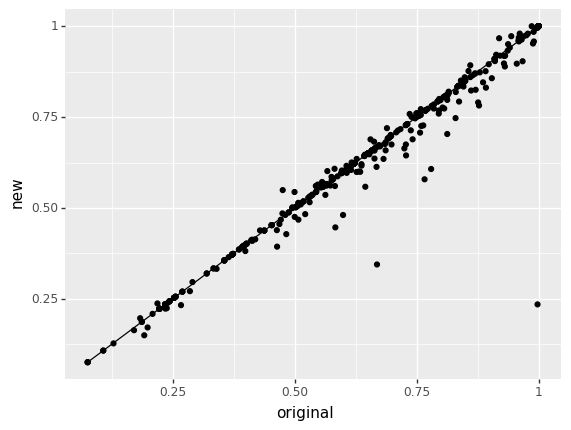

<ggplot: (8754359857489)>

In [201]:
# pretty much the same
ggplot(d, aes(x='original', y='new')) + geom_point() + geom_line(aes(y='original'))

## Do some analysis on the existing

In [219]:
X_on_disk = np.load('/storage/thesis/music_ftr/X_on_disk_v2.npy', mmap_mode='r')
X_on_disk = np.load('/storage/thesis/music_ftr/X_on_disk_samples.npy', mmap_mode='r')
y_on_disk = np.load('/storage/thesis/music_ftr/genres.npy', allow_pickle=True).astype('unicode')
id_on_disk = np.load('/storage/thesis/music_ftr/track_ids.npy', allow_pickle=True)

In [220]:
samples = 1000

# pitch, timbre, bpm
X_ram = X_on_disk[:samples]

y_ram = y_on_disk[:samples]
id_ram = id_on_disk[:samples]

In [221]:
result = pd.DataFrame()
for i in np.arange(0, samples):
    dt = pd.DataFrame(X_ram[i].T)
    dt.loc[:,'genre'] = y_ram[i]
    dt.loc[:,'track_id'] = id_ram[i]
    result = pd.concat([result, dt])
    if i % 100 == 0:
        print(i)

0
100
200
300
400
500
600
700
800
900


In [222]:
result.loc[:,'ftr_sum'] = result.iloc[:,:24].sum(axis=1)

In [223]:
result.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,genre,track_id,ftr_sum
0,0.8800,1.0000,0.6150,0.487,0.3980,0.4090,0.3960,0.3460,0.3220,0.1930,0.1420,0.5390,0.000000,171.130005,9.469000,-28.4800,57.491001,-50.067001,14.833000,5.359000,-27.228001,0.9730,-10.640000,-7.2280,0.027036,Hip_Hop_Rap,TRAAAHZ128E0799171,141.339005
1,0.8800,1.0000,0.6150,0.487,0.3980,0.4090,0.3960,0.3460,0.3220,0.1930,0.1420,0.5390,0.000000,171.130005,9.469000,-28.4800,57.491001,-50.067001,14.833000,5.359000,-27.228001,0.9730,-10.640000,-7.2280,0.027036,Hip_Hop_Rap,TRAAAHZ128E0799171,141.339005
2,0.6415,0.7525,0.4641,0.418,0.3872,0.5863,0.5052,0.2671,0.2407,0.1582,0.1315,0.3989,13.771800,143.239899,36.889000,-16.8421,17.366600,9.047100,29.457100,-2.625500,-14.944200,9.9634,7.557700,-10.2712,0.027036,Hip_Hop_Rap,TRAAAHZ128E0799171,227.560791
3,0.0850,0.1750,0.1120,0.257,0.3620,1.0000,0.7600,0.0830,0.0510,0.0770,0.1070,0.0720,45.905998,78.163002,100.869003,10.3130,-76.257004,146.979996,63.580002,-21.256001,13.718000,30.9410,50.019001,-17.3720,0.027036,Hip_Hop_Rap,TRAAAHZ128E0799171,428.745026
4,0.0850,0.1750,0.1120,0.257,0.3620,1.0000,0.7600,0.0830,0.0510,0.0770,0.1070,0.0720,45.905998,78.163002,100.869003,10.3130,-76.257004,146.979996,63.580002,-21.256001,13.718000,30.9410,50.019001,-17.3720,0.027036,Hip_Hop_Rap,TRAAAHZ128E0799171,428.745026


In [224]:
og = result.copy()

In [225]:
# values for 13+ are way larger 

In [226]:
result = result.loc[result['ftr_sum'] > 0, :]

In [227]:
pitch_classes = ['B♯/C','C♯/D♭','D','D♯/E♭','E/F♭','E♯/F','F♯/G♭','G','G♯/A♭','A','A♯/B♭','B/C♭']
for i,p in zip(np.arange(0,12), pitch_classes):
    result.rename(columns={i:p}, inplace=True)

## pitch

In [211]:
result.head()

,B♯/C,C♯/D♭,D,D♯/E♭,E/F♭,E♯/F,F♯/G♭,G,G♯/A♭,A,A♯/B♭,B/C♭,12,13,14,15,16,17,18,19,20,21,22,23,genre,track_id,ftr_sum
0,0.8800,1.0000,0.6150,0.487,0.3980,0.4090,0.3960,0.3460,0.3220,0.1930,0.1420,0.5390,0.000000,171.130005,9.469000,-28.4800,57.491001,-50.067001,14.833000,5.359000,-27.228001,0.9730,-10.640000,-7.2280,Hip_Hop_Rap,TRAAAHZ128E0799171,141.339005
1,0.8800,1.0000,0.6150,0.487,0.3980,0.4090,0.3960,0.3460,0.3220,0.1930,0.1420,0.5390,0.000000,171.130005,9.469000,-28.4800,57.491001,-50.067001,14.833000,5.359000,-27.228001,0.9730,-10.640000,-7.2280,Hip_Hop_Rap,TRAAAHZ128E0799171,141.339005
2,0.6415,0.7525,0.4641,0.418,0.3872,0.5863,0.5052,0.2671,0.2407,0.1582,0.1315,0.3989,13.771800,143.239899,36.889000,-16.8421,17.366600,9.047100,29.457100,-2.625500,-14.944200,9.9634,7.557700,-10.2712,Hip_Hop_Rap,TRAAAHZ128E0799171,227.560791
3,0.0850,0.1750,0.1120,0.257,0.3620,1.0000,0.7600,0.0830,0.0510,0.0770,0.1070,0.0720,45.905998,78.163002,100.869003,10.3130,-76.257004,146.979996,63.580002,-21.256001,13.718000,30.9410,50.019001,-17.3720,Hip_Hop_Rap,TRAAAHZ128E0799171,428.745026
4,0.0850,0.1750,0.1120,0.257,0.3620,1.0000,0.7600,0.0830,0.0510,0.0770,0.1070,0.0720,45.905998,78.163002,100.869003,10.3130,-76.257004,146.979996,63.580002,-21.256001,13.718000,30.9410,50.019001,-17.3720,Hip_Hop_Rap,TRAAAHZ128E0799171,428.745026


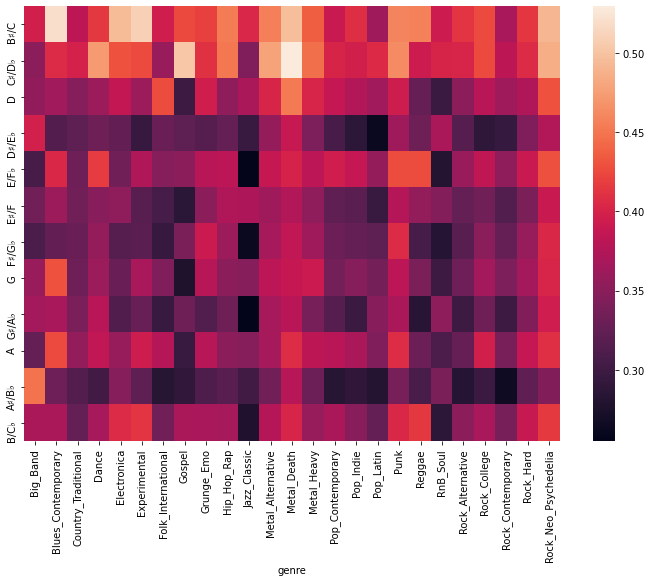

In [212]:
plt.subplots(figsize=(12,8))
sns.heatmap(pd.concat([result['genre'], result.iloc[:,:12]], axis=1).groupby(['genre']).mean().T)

## timbre

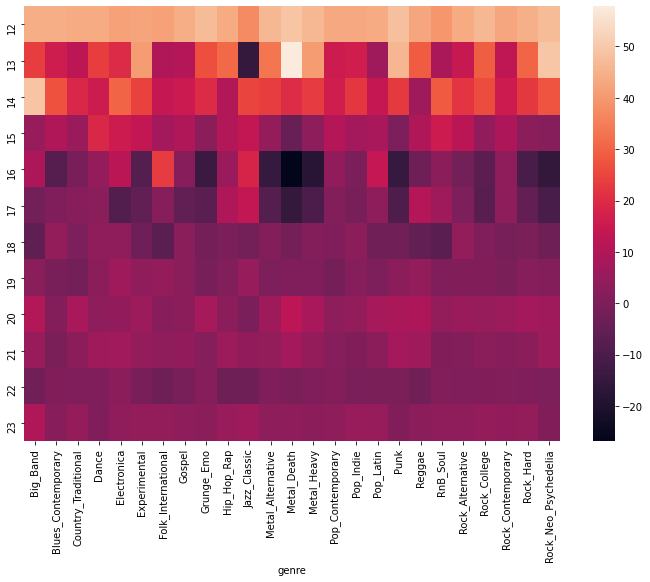

In [213]:
plt.subplots(figsize=(12,8))
sns.heatmap(pd.concat([result['genre'], result.iloc[:,12:24]], axis=1).groupby(['genre']).mean().T)

## bpm

In [233]:
result.loc[:,'bpm'] = result[24]*60*60

In [243]:
(result[['genre','bpm','track_id']]
       .drop_duplicates()
       .reset_index(drop=True)
       .groupby(['genre'])
       .agg({'bpm':['mean','std','count']}))

bpm                 
                            mean        std count
genre                                            
Big_Band              113.961205  35.967398     8
Blues_Contemporary    123.711075  36.343006    12
Country_Traditional   122.802887  30.687792    43
Dance                 123.077057  35.355345    19
Electronica           119.206841  31.636656    19
Experimental          128.852295  38.640587    31
Folk_International    115.582436  37.377881    22
Gospel                128.985428  27.563741    18
Grunge_Emo            121.981293  28.519955    29
Hip_Hop_Rap           128.614273  38.493197    47
Jazz_Classic          105.305069  34.221390    12
Metal_Alternative     138.701126  40.514565    88
Metal_Death           134.338242  41.072495    74
Metal_Heavy           124.947601  37.663729    53
Pop_Contemporary      111.581108  27.526794    62
Pop_Indie             116.771263  31.198511    72
Pop_Latin             132.623764  31.822383    22
Punk                  147.048309  35.890622    37
Reggae                157.336975  42.975169    10
RnB_Soul              116.816925  29.604145    10
Rock_Alternative      126.697975  39.720401    51
Rock_College          135.434616  38.219708    66
Rock_Contemporary     123.508408  31.639281    82
Rock_Hard             125.184471  33.896166    65
Rock_Neo_Psychedelia  135.023315  38.588975    48

In [228]:
result.head()

,B♯/C,C♯/D♭,D,D♯/E♭,E/F♭,E♯/F,F♯/G♭,G,G♯/A♭,A,A♯/B♭,B/C♭,12,13,14,15,16,17,18,19,20,21,22,23,24,genre,track_id,ftr_sum
0,0.8800,1.0000,0.6150,0.487,0.3980,0.4090,0.3960,0.3460,0.3220,0.1930,0.1420,0.5390,0.000000,171.130005,9.469000,-28.4800,57.491001,-50.067001,14.833000,5.359000,-27.228001,0.9730,-10.640000,-7.2280,0.027036,Hip_Hop_Rap,TRAAAHZ128E0799171,141.339005
1,0.8800,1.0000,0.6150,0.487,0.3980,0.4090,0.3960,0.3460,0.3220,0.1930,0.1420,0.5390,0.000000,171.130005,9.469000,-28.4800,57.491001,-50.067001,14.833000,5.359000,-27.228001,0.9730,-10.640000,-7.2280,0.027036,Hip_Hop_Rap,TRAAAHZ128E0799171,141.339005
2,0.6415,0.7525,0.4641,0.418,0.3872,0.5863,0.5052,0.2671,0.2407,0.1582,0.1315,0.3989,13.771800,143.239899,36.889000,-16.8421,17.366600,9.047100,29.457100,-2.625500,-14.944200,9.9634,7.557700,-10.2712,0.027036,Hip_Hop_Rap,TRAAAHZ128E0799171,227.560791
3,0.0850,0.1750,0.1120,0.257,0.3620,1.0000,0.7600,0.0830,0.0510,0.0770,0.1070,0.0720,45.905998,78.163002,100.869003,10.3130,-76.257004,146.979996,63.580002,-21.256001,13.718000,30.9410,50.019001,-17.3720,0.027036,Hip_Hop_Rap,TRAAAHZ128E0799171,428.745026
4,0.0850,0.1750,0.1120,0.257,0.3620,1.0000,0.7600,0.0830,0.0510,0.0770,0.1070,0.0720,45.905998,78.163002,100.869003,10.3130,-76.257004,146.979996,63.580002,-21.256001,13.718000,30.9410,50.019001,-17.3720,0.027036,Hip_Hop_Rap,TRAAAHZ128E0799171,428.745026


### Thesis Charts

In [ ]:
result.loc[:,'is_metal_death'] = np.where(result['genre']=='Metal_Death', 1, 0)
(ggplot(result, aes(x='genre', y='C♯/D♭')) + 
     geom_boxplot(aes(fill='factor(is_metal_death)')) + 
     coord_flip() + 
     scale_fill_manual(values=['dodgerblue','orange']) +
     theme(legend_position='none'))

In [ ]:
top5 = result.genre.value_counts().nlargest(5).index.tolist()
(ggplot(result.loc[result['genre'].isin(top5),['genre','C♯/D♭']], aes(fill='genre', x='C♯/D♭')) + 
     geom_density(alpha=0.25, bw=.01))

In [ ]:
(ggplot(result.loc[:,['genre','bpm']], aes(x='genre', y='bpm')) + 
     geom_boxplot(aes(fill='genre')) + 
     coord_flip())